###Imports - data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score


ModuleNotFoundError: No module named 'pandas'

In [ ]:
data = pd.read_csv('DATA.csv')
df = data.copy()

In [ ]:
mun = pd.read_csv('/content/DIVIPOLA-_C_digos_municipios.csv')
mun.head()

,Código Departamento,Nombre Departamento,Código Municipio,Nombre Municipio,Tipo: Municipio / Isla / Área no municipalizada,longitud,Latitud
0,5,ANTIOQUIA,5001,MEDELLÍN,Municipio,"-75,581775","6,246631"
1,5,ANTIOQUIA,5002,ABEJORRAL,Municipio,"-75,428739","5,789315"
2,5,ANTIOQUIA,5004,ABRIAQUÍ,Municipio,"-76,064304","6,632282"
3,5,ANTIOQUIA,5021,ALEJANDRÍA,Municipio,"-75,141346","6,376061"
4,5,ANTIOQUIA,5030,AMAGÁ,Municipio,"-75,702188","6,038708"


###**Conversiones**

Nos aseguramos del formato de las variables temporales (fechas) y sacamos información relevante sobre ellas, como lo es el día del año que representan.

In [ ]:
# Convertir columnas de fecha a datetime
fechas = ["FEC_NOT", "FEC_CON", "INI_SIN", "FEC_HOS", "FEC_DEF"]
for col in fechas:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Convierte y maneja errores como NaT

# Extraer variables temporales
for col in ["FEC_NOT", "FEC_CON", "INI_SIN", "FEC_HOS", "FEC_DEF"]:
    df[f"{col}_dia_ano"] = df[col].dt.dayofyear

Enlistamos las variables binarias, pues, posteriormente se necesitará diferenciar de las númericas y categoricas, para un preprocesamiento adecuado a nuestros diferentes modelos.  

In [ ]:
# Lista de variables binarias que tienen valores 1 y 2
binarias_1_2 = ["GP_DISCAPA", "GP_DESPLAZ", "GP_MIGRANT", "GP_CARCELA",
                 "GP_GESTAN", "GP_INDIGEN", "GP_POBICFB", "GP_MAD_COM",
                 "GP_DESMOVI", "GP_PSIQUIA", "GP_VIC_VIO", "GP_OTROS", "CON_FIN"]

In [ ]:
# Convertir 1 → 0 y 2 → 1
df[binarias_1_2] = df[binarias_1_2] - 1

# Verificar que el cambio fue exitoso
print(df[binarias_1_2].describe())

          GP_DISCAPA     GP_DESPLAZ     GP_MIGRANT     GP_CARCELA  \
count  582479.000000  582479.000000  582479.000000  582479.000000   
mean        0.994199       0.989948       0.968888       0.998726   
std         0.075944       0.099754       0.173620       0.035669   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       1.000000       1.000000   
50%         1.000000       1.000000       1.000000       1.000000   
75%         1.000000       1.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

           GP_GESTAN     GP_INDIGEN     GP_POBICFB     GP_MAD_COM  \
count  582479.000000  582479.000000  582479.000000  582479.000000   
mean        0.947193       0.998498       0.995234       0.999420   
std         0.223648       0.038729       0.068870       0.024082   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.0000

Estamos buscando hacer un merge con el dataset mun, para esto, primero nos aseguramos de que los códigos de municipio de este dataset mun sean enteros de 5 cifras, que no contengan espacio. Por otro lado, nos vamos modificando nuestro código de municipio en nuestro dataset, pues, este se encontraba separado entre COD_DPTO_ y COD_MUN_, para esto nos aseguramos de que estas variables tengan 2 y 3 cifras respectivamente, para posteriormente concatenar y tener nuestros códigos de municipios listos.

In [ ]:
mun['Código Municipio'] = mun['Código Municipio'].astype(str).str.zfill(5)
mun["Código Municipio"] = mun["Código Municipio"].astype(str).str.strip()

mun['Latitud'] = mun['Latitud'].str.replace(',', '.').astype(float)
mun['longitud'] = mun['longitud'].str.replace(',', '.').astype(float)

# asegurar que los COD_DPTO_ tenga 2 cifras y COD_MUN 3
df['COD_DPTO_O'] = df['COD_DPTO_O'].astype(str).str.zfill(2)
df['COD_MUN_O'] = df['COD_MUN_O'].astype(str).str.zfill(3)
df["COD_MUN_O"] = df["COD_MUN_O"].astype(str).str.strip()
df['COD_DPTO_R'] = df['COD_DPTO_R'].astype(str).str.zfill(2)
df['COD_MUN_R'] = df['COD_MUN_R'].astype(str).str.zfill(3)

df['COD_DPTO_N'] = df['COD_DPTO_N'].astype(str).str.zfill(2)
df['COD_MUN_N'] = df['COD_MUN_N'].astype(str).str.zfill(5)

# Concatenar COD_DPTO_O y COD_MUN_O
df['COD_MUN_O'] = df['COD_DPTO_O'] + df['COD_MUN_O']
df['COD_MUN_R'] = df['COD_DPTO_R'] + df['COD_MUN_R']
print(df[['COD_MUN_O', 'COD_MUN_R', 'COD_MUN_N']].head())

df = df[df["COD_MUN_O"].isin(mun["Código Municipio"])]
df = df[df["COD_MUN_R"].isin(mun["Código Municipio"])]
df = df[df["COD_MUN_N"].isin(mun["Código Municipio"])]

  COD_MUN_O COD_MUN_R COD_MUN_N
0     08758     08758     08758
1     11001     11001     11001
2     68081     68081     68081
3     25754     25754     25754
4     11001     11001     11001


In [ ]:
!pip install geopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.6 MB/s eta 0:00:00


Para aprovehar al máximo nuestras variables de locación, hemos tenido en cuenta las distancias entre municipios de ocurrencia, residencia y notificación. Para poder llegar a estos acercamientos, nos valemos de geodesic, usándola en la función calcular_distancia, en donde después de unir las bases de datos mediante las variables de COD_MUN_ y asignadas las coordenadas de cada municipio, utilizaba geodesic para calcular esta distancia en kilometros.  

In [ ]:
from geopy.distance import geodesic


# Unir df con mun para obtener coordenadas del municipio de ocurrencia (O)
df = df.merge(mun[['Código Municipio', 'Latitud', 'longitud']],
              left_on='COD_MUN_O',
              right_on='Código Municipio',
              how='left')
df["coord_O"] = list(zip(df["Latitud"], df["longitud"]))
df.drop(columns=['Código Municipio', 'Latitud', 'longitud'], inplace=True)

# Unir df con mun para obtener coordenadas del municipio de notificación (N)
df = df.merge(mun[['Código Municipio', 'Latitud', 'longitud']],
              left_on='COD_MUN_N',
              right_on='Código Municipio',
              how='left')
df["coord_N"] = list(zip(df["Latitud"], df["longitud"]))
df.drop(columns=['Código Municipio', 'Latitud', 'longitud'], inplace=True)


# Unir df con mun para obtener coodenadas del municipio de residencia (R)
df = df.merge(mun[['Código Municipio', 'Latitud', 'longitud']],
              left_on='COD_MUN_R',
              right_on='Código Municipio',
              how='left')
df["coord_R"] = list(zip(df["Latitud"], df["longitud"]))
df.drop(columns=['Código Municipio', 'Latitud', 'longitud'], inplace=True)


# Función para calcular distancia geográfica
def calcular_distancia(row, a):
  if a == 'ON':
    if pd.isna(row["coord_O"]) or pd.isna(row["coord_N"]):
        return np.nan  # Si faltan datos, dejamos NaN
    return geodesic(row["coord_O"], row["coord_N"]).km

  if a == 'RO':
    if pd.isna(row["coord_R"]) or pd.isna(row["coord_O"]):
        return np.nan  # Si faltan datos, dejamos NaN
    return geodesic(row["coord_R"], row["coord_O"]).km

  if a == 'RN':
    if pd.isna(row["coord_R"]) or pd.isna(row["coord_N"]):
        return np.nan  # Si faltan datos, dejamos NaN
    return geodesic(row["coord_R"], row["coord_N"]).km

# Aplicar la función a cada fila
df["distancia_O_N"] = df.apply(lambda row: calcular_distancia(row, 'ON'), axis=1)
df["distancia_R_O"] = df.apply(lambda row: calcular_distancia(row, 'RO'), axis=1)
df["distancia_R_N"] = df.apply(lambda row: calcular_distancia(row, 'RN'), axis=1)

# Verificar resultados
df[['coord_O_lat', 'coord_O_lon']] = df['coord_O'].apply(pd.Series)
df[['coord_R_lat', 'coord_R_lon']] = df['coord_R'].apply(pd.Series)
df[['coord_N_lat', 'coord_N_lon']] = df['coord_N'].apply(pd.Series)








###Selección de variables

En este espacio ya definimos nuestras variables númericas y categóricas que serán utilizadas en nuestros conjuntos de entrenamiento y de prueba para nuestos modelos.

In [ ]:
variables_numericas = ['coord_O_lat', 'coord_O_lon', 'coord_R_lat', 'coord_R_lon',
                       'coord_N_lat', 'coord_N_lon', "distancia_O_N","distancia_R_O",
                       "distancia_R_N", "INI_SIN_dia_ano", "FEC_NOT_dia_ano", "FEC_CON_dia_ano",
                       "FEC_HOS_dia_ano", "FEC_DEF_dia_ano", 'SEMANA', 'ANO', 'EDAD', "sem_ges"]
variables_categoricas = ["UNI_MED", "TIP_SS", "PER_ETN", "TIP_CAS", "estrato",
                          "CBMTE", "COD_DPTO_O","COD_DPTO_N", "COD_DPTO_R",
                          "Estado_final_de_caso", "Desenlace_Grave"]

- from sklearn.pipeline import Pipeline: Esta línea importa la clase Pipeline del módulo sklearn.pipeline. Los pipelines se utilizan para encadenar múltiples transformaciones de datos y un estimador final en un único objeto, haciendo el código más limpio y fácil de manejar.
- from sklearn.compose import ColumnTransformer: Importa la clase ColumnTransformer, utilizada para aplicar diferentes pasos de preprocesamiento a diferentes columnas del conjunto de datos. Esto es útil cuando se tiene una mezcla de características numéricas y categóricas.
- from sklearn.preprocessing import OneHotEncoder: Importa la clase OneHotEncoder, que convierte características categóricas en una representación numérica que los modelos de aprendizaje automático pueden entender.
- from sklearn.linear_model import LinearRegression: Importa la clase LinearRegression, que es el modelo de aprendizaje automático utilizado para la predicción en este caso. Es un algoritmo sencillo y muy utilizado para tareas de regresión.
- from sklearn.model_selection import train_test_split: Importa la función train_test_split, utilizada para dividir el conjunto de datos en conjuntos de entrenamiento y de prueba. Esto es esencial para evaluar el rendimiento del modelo en datos no vistos.
import pandas as pd: Importa la librería pandas, ampliamente utilizada para la manipulación y análisis de datos en Python. Proporciona estructuras de datos como DataFrames, que se utilizan para almacenar y trabajar con datos tabulares.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

X = df[variables_numericas + variables_categoricas + binarias_1_2]
y = df["DiferenciaDias"]

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- X = df[variables_numericas + variables_categoricas + binarias_1_2]: This line creates a new DataFrame called X that contains the features (input variables) for the machine learning model. It selects columns from the original DataFrame (df) based on three lists: variables_numericas, variables_categoricas, and binarias_1_2. These lists presumably contain the names of the respective types of features.
- y = df["DiferenciaDias"]: This line creates a Series called y that contains the target variable (the variable we want to predict). In this case, the target variable is "DiferenciaDias", which is likely a column in the original DataFrame representing some difference in days.
- X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42): Esta línea utiliza la función train_test_split para dividir los datos en conjuntos de entrenamiento y de prueba.
- X e y son las características y la variable objetivo, respectivamente.
test_size=0.2 indica que el 20% de los datos se utilizarán para las pruebas y el 80% restante para el entrenamiento.
random_state=42 asegura que la división es reproducible, lo que significa que obtendrá la misma división cada vez que ejecute el código con esta semilla. Esto es útil para obtener resultados y comparaciones consistentes.


##Modelaje

###Lineal Regression

In [ ]:
from scipy import stats

Declaramos el preprocesador que contiene el OneHotEncoder, que será utilizado para las variables categóricas en el pipeline que se define después en donde también se encuentra el modelo.

In [ ]:
# Preprocesador: MinMaxScaler para numéricas y OneHotEncoder para categóricas
preprocessor = ColumnTransformer([
   ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)  # Codificar categóricas
], remainder='passthrough')  # Dejar las numéricas sin cambios

Se define un diccionario param_grid para especificar los hiperparámetros que se ajustarán durante la búsqueda en la cuadrícula. En este caso, está explorando dos opciones para el parámetro fit_intercept del modelo LinearRegression: Verdadero y Falso. Los hiperparámetros son ajustes que controlan el proceso de aprendizaje de un modelo, y encontrar valores óptimos para ellos puede mejorar significativamente el rendimiento.
GridSearchCV se utiliza para encontrar la mejor combinación de hiperparámetros de param_grid mediante el entrenamiento exhaustivo y la evaluación del modelo con cada combinación.
cv=5 especifica una validación cruzada de 5 veces, lo que ayuda a garantizar una evaluación robusta.
scoring='r2' indica que se utilizará la métrica R-cuadrado para evaluar el rendimiento del modelo.
n_jobs=-1 utiliza todos los núcleos de procesador disponibles para un cálculo más rápido.
grid_search.fit entrena el modelo utilizando la canalización, la cuadrícula de hiperparámetros y la estrategia de validación cruzada especificadas en los datos de entrenamiento (X_train, y_train).


Mejor configuración: {'model__fit_intercept': True}

Ridge Regression con GridSearch
⏳ Tiempo de entrenamiento: 26.3228 segundos
⏳ Tiempo de predicción: 0.5239 segundos
MAE: 23.305705800341194
RMSE: 169.8534769908094
R²: 0.056284495295316095


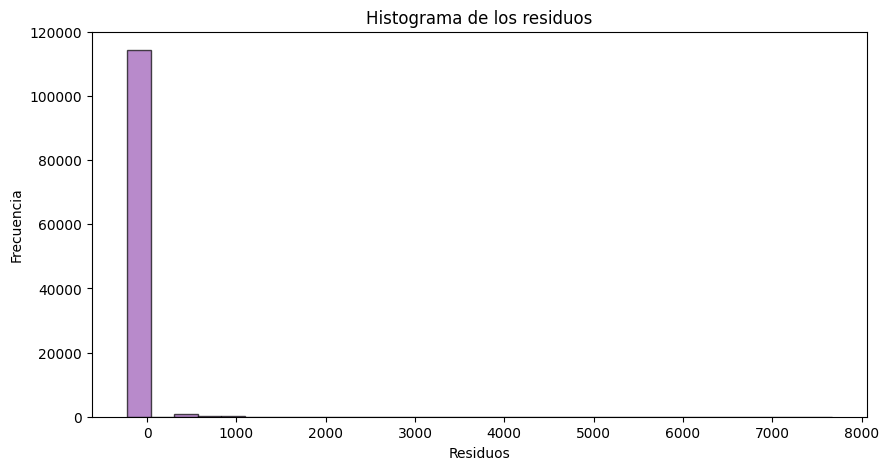

<Figure size 1000x500 with 0 Axes>

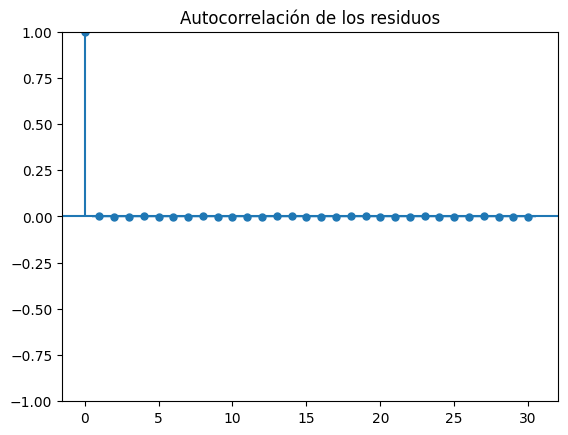


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  3.650346   0.961745

Test de Jarque-Bera: Estadístico=3397336161.9220176, p-valor=0.0
Los residuos no siguen una distribución normal (rechazar H0).


<ipython-input-30-c278db07aa77>:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


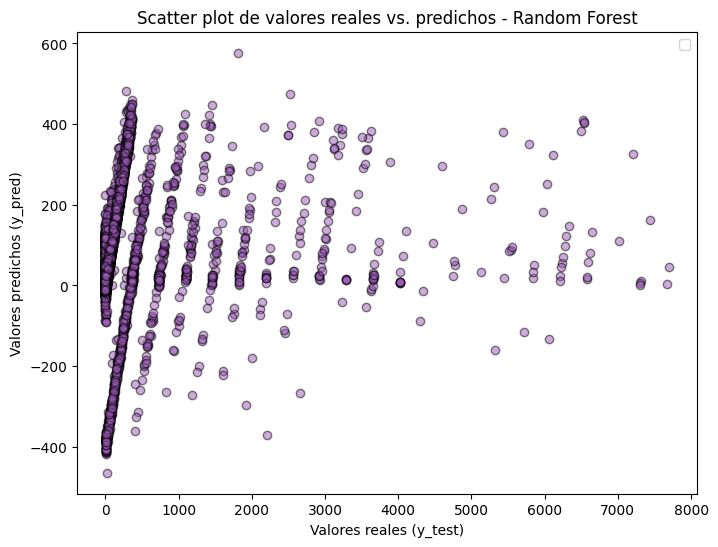

In [ ]:
# Crear pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # Modelo Lineal
])

# Definir hiperparámetros para GridSearch
param_grid = {
    'model__fit_intercept': [True, False]
}

# Grid Search con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

start_train = time.perf_counter()
grid_search.fit(X_train, y_train)  # Entrenar el modelo con GridSearchCV
end_train = time.perf_counter()
train_time = end_train - start_train

# Mejor modelo
best_model_lr = grid_search.best_estimator_

start_pred = time.perf_counter()
y_pred_lr = best_model_lr.predict(X_test)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# Evaluación
print(f"\nMejor configuración: {grid_search.best_params_}")
print(f"\nRidge Regression con GridSearch")
print(f"⏳ Tiempo de entrenamiento: {train_time:.4f} segundos")
print(f"⏳ Tiempo de predicción: {pred_time:.4f} segundos")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr))}")
print(f"R²: {r2_score(y_test, y_pred_lr)}")

# Análisis de residuos
residuos_lr = y_test - y_pred_lr

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos_lr, bins=30, edgecolor='k', alpha=0.7, color='#9b59b6' )
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos_lr, lags=30)
plt.title("Autocorrelación de los residuos")
plt.show()

# Prueba de Ljung-Box
ljung_box_test = sm.stats.acorr_ljungbox(residuos_lr, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test)

# Test de Jarque-Bera
jb_stat, jb_pvalue = stats.jarque_bera(residuos_lr)
print(f"\nTest de Jarque-Bera: Estadístico={jb_stat}, p-valor={jb_pvalue}")
if jb_pvalue < 0.05:
    print("Los residuos no siguen una distribución normal (rechazar H0).")
else:
    print("Los residuos siguen una distribución normal (no rechazar H0).")

# Gráfico de dispersión de valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, edgecolors='k', color='#9b59b6')  # Morado claro feminista
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Valores predichos (y_pred)")
plt.title("Scatter plot de valores reales vs. predichos - Random Forest")
plt.legend()
plt.show()


Los resultados del modelo de regresión lineal para la predicción de "Diferenciadias" muestran un desempeño limitado en la tarea. El histograma de residuos sugiere que la mayoría de los errores están cerca de cero, pero con la presencia de valores atípicos que pueden estar afectando la precisión del modelo. La prueba de Ljung-Box indica que no hay una autocorrelación significativa en los residuos, lo cual es deseable, pero el test de Jarque-Bera rechaza la hipótesis de normalidad de los errores, sugiriendo que el modelo podría no estar capturando adecuadamente la estructura de la variable objetivo. En términos de desempeño, el coeficiente de determinación R² es de apenas 0.056, lo que indica que la regresión lineal explica muy poca variabilidad en los tiempos de consulta de las víctimas. Además, el scatter plot de valores reales vs. predichos evidencia que el modelo tiene problemas de ajuste, con predicciones negativas en algunos casos y una dispersión elevada, lo que sugiere que no logra capturar correctamente los patrones de la variable dependiente. Finalmente, las métricas de error (MAE: 23.30 y RMSE: 169.85) muestran que el modelo tiene una precisión moderada, pero podría beneficiarse de mejoras en la selección de variables o en la elección de una metodología más robusta para datos con alta variabilidad.

###Ridge

In [ ]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.6 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf

Para Ridge es prácticamente el mismo código, solo añadimos RobustScaler() para las variables númericas en el Preprocessor. Esto para que la penalizacion afecte a todas las variables númericas por igual. También se añade el hiperparámetro alpha a param_grid para verificar cual es mejor ajuste de regularizacion según la métrica $R^2$

In [ ]:
# Preprocesador: MinMaxScaler para numéricas y OneHotEncoder para categóricas
preprocessor = ColumnTransformer([
   ('num', RobustScaler(), variables_numericas),
   ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)  # Codificar categóricas
])


Mejor configuración: {'model__alpha': 100, 'model__fit_intercept': False}

Ridge Regression con GridSearch
⏳ Tiempo de entrenamiento: 355.5241 segundos
⏳ Tiempo de predicción: 0.4157 segundos
MAE: 23.123023705430224
RMSE: 169.86331552502213
R²: 0.056175165226262425


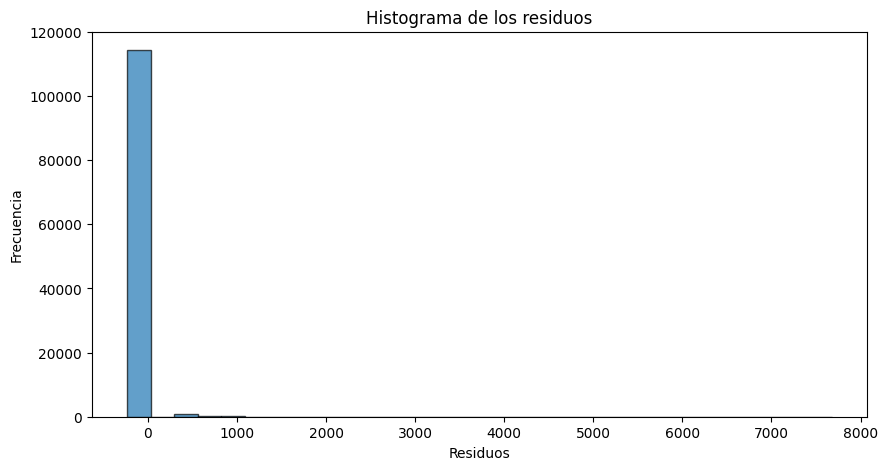

<Figure size 1000x500 with 0 Axes>

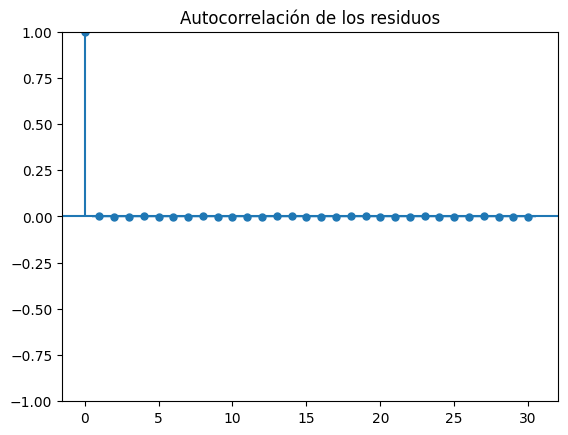


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  3.642833   0.962025


In [ ]:
# Crear pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())  # Modelo Ridge
])

# Definir hiperparámetros para GridSearch
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],  # Ajuste de regularización
    'model__fit_intercept': [True, False]
}

# Grid Search con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

start_train = time.perf_counter()
grid_search.fit(X_train, y_train)  # Entrenar el modelo con GridSearchCV
end_train = time.perf_counter()
train_time = end_train - start_train

# Mejor modelo
best_model = grid_search.best_estimator_

start_pred = time.perf_counter()
y_pred = best_model.predict(X_test)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# Evaluación
print(f"\nMejor configuración: {grid_search.best_params_}")
print(f"\nRidge Regression con GridSearch")
print(f"⏳ Tiempo de entrenamiento: {train_time:.4f} segundos")
print(f"⏳ Tiempo de predicción: {pred_time:.4f} segundos")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

# Análisis de residuos
residuos = y_test - y_pred

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos, lags=30)
plt.title("Autocorrelación de los residuos")
plt.show()

# Prueba de Ljung-Box
ljung_box_test = sm.stats.acorr_ljungbox(residuos, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test)


Los resultados del modelo Ridge Regression muestran un rendimiento limitado en la predicción de la variable "Diferenciadias" dentro del conjunto de datos de violencia basada en género. El histograma de residuos revela una distribución altamente concentrada cerca de cero, pero con valores atípicos dispersos, lo que indica que el modelo tiene dificultades para ajustar correctamente la variabilidad de los datos. La prueba de Ljung-Box sugiere que los residuos no presentan autocorrelación significativa, lo que es favorable en términos de independencia temporal. Sin embargo, la métrica $R2=0.056R^2 = 0.056$ indica que el modelo solo explica aproximadamente el $5.6\%$ de la varianza de los datos, lo que es muy bajo. Además, el error cuadrático medio (RMSE) de 169.86 y el error absoluto medio (MAE) de 23.12 reflejan que las predicciones están lejos de ser precisas. En conjunto, estos resultados sugieren que Ridge Regression no captura adecuadamente las relaciones subyacentes en los datos, lo que podría deberse a una estructura de datos compleja o a la falta de características predictivas relevantes.

####Ridge (Saga solver)

Para el ridge con solver saga se utilizan los "mejores" hiperparámetros en la celda de código anterior y se hace lo mismo. En cuanto a los tiempos, se muestra una mayor ventana de tiempo en el entrenamiento del modelo de machine learning, sin embargo, se muestra una ligera disminución en los tiempos de entrenamiento para el modelo Ridge con solver saga.  

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Mejor configuración: {'model__alpha': 100, 'model__fit_intercept': False}

Ridge Regression con GridSearch
⏳ Tiempo de entrenamiento: 755.1124 segundos
⏳ Tiempo de predicción: 0.3926 segundos
MAE: 23.952009471014172
RMSE: 170.40339927537715
R²: 0.05016380454931002


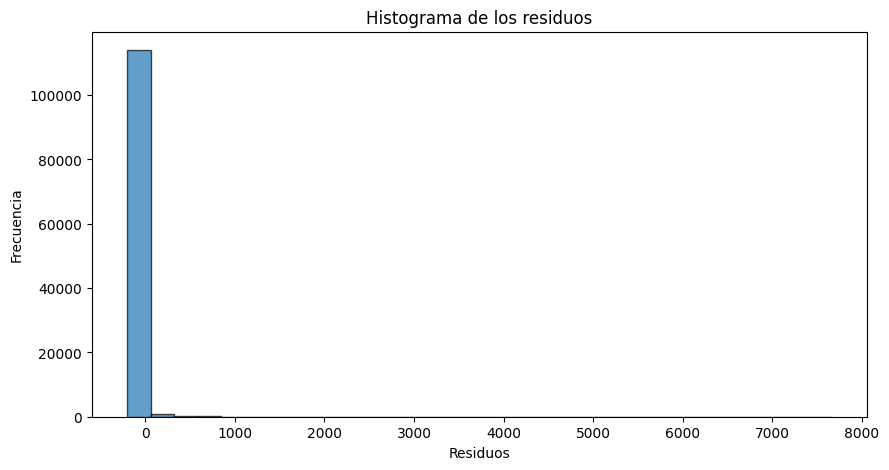

<Figure size 1000x500 with 0 Axes>

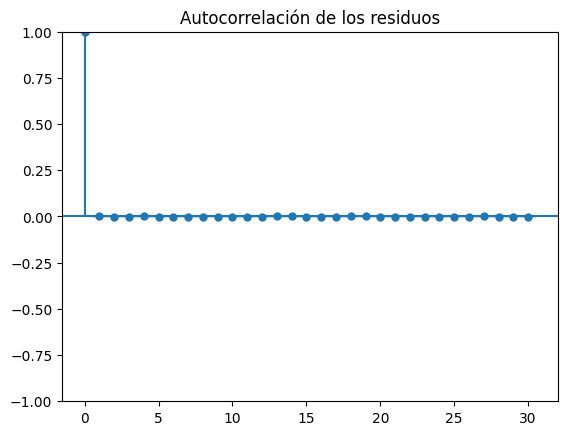


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  3.805205   0.955707


In [ ]:
# Crear pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(solver='saga'))  # Modelo Ridge
])

# Definir hiperparámetros para GridSearch
param_grid = {
    'model__alpha': [100],  # Ajuste de regularización
    'model__fit_intercept': [False]
}

# Grid Search con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

start_train = time.perf_counter()
grid_search.fit(X_train, y_train)  # Entrenar el modelo con GridSearchCV
end_train = time.perf_counter()
train_time = end_train - start_train

# Mejor modelo
best_model = grid_search.best_estimator_

start_pred = time.perf_counter()
y_pred = best_model.predict(X_test)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# Evaluación
print(f"\nMejor configuración: {grid_search.best_params_}")
print(f"\nRidge Regression con GridSearch")
print(f"⏳ Tiempo de entrenamiento: {train_time:.4f} segundos")
print(f"⏳ Tiempo de predicción: {pred_time:.4f} segundos")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

# Análisis de residuos
residuos = y_test - y_pred

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos, lags=30)
plt.title("Autocorrelación de los residuos")
plt.show()

# Prueba de Ljung-Box
ljung_box_test = sm.stats.acorr_ljungbox(residuos, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test)


###**LASSO**

Volvemos a usar el mismo preprocessor de Ridge en Lasso, al igual que los hiper parametros del param_grid para su comparación en los modelos.


Mejor configuración: {'model__alpha': 0.01, 'model__fit_intercept': False}

Lasso Regression con GridSearch
⏳ Tiempo de entrenamiento: 2062.3101 segundos
⏳ Tiempo de predicción: 0.5649 segundos
MAE: 23.061307691773806
RMSE: 169.87228768525995
R²: 0.056075457160737585


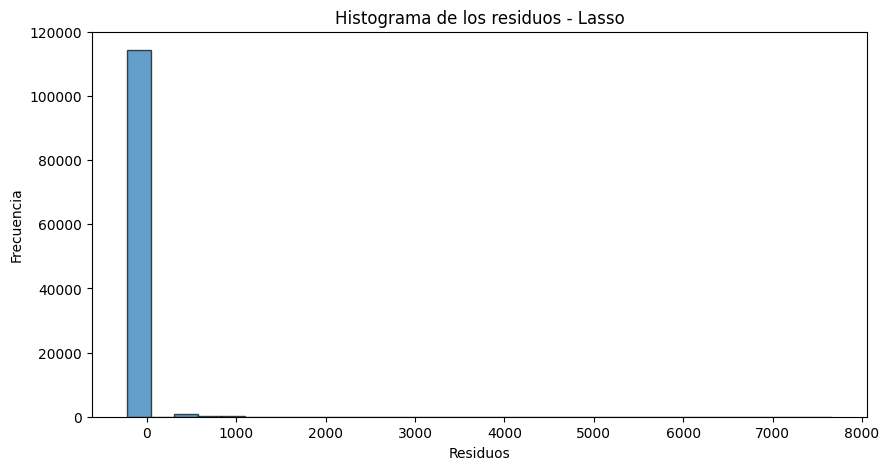

<Figure size 1000x500 with 0 Axes>

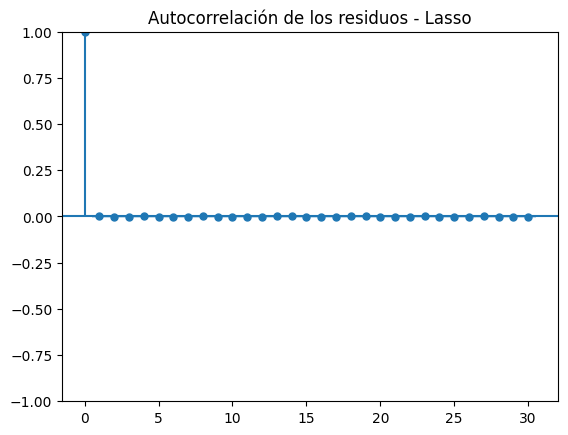


Prueba de Ljung-Box:
    lb_stat  lb_pvalue
10  3.72496   0.958903


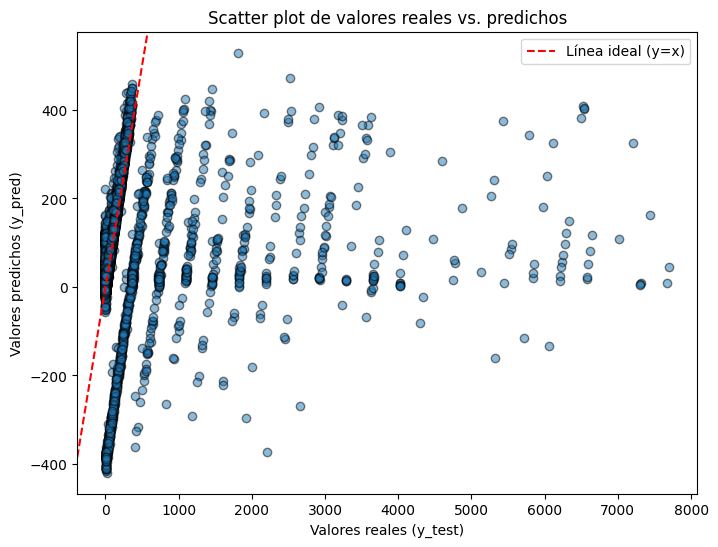

In [ ]:
from sklearn.linear_model import Lasso

# Crear pipeline con preprocesamiento y modelo Lasso
pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Lasso())
])

# Definir hiperparámetros para GridSearch
param_grid_lasso = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],  # Ajuste de regularización
    'model__fit_intercept': [True, False]
}

# Grid Search con validación cruzada
grid_search_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='r2', n_jobs=-1)

start_train = time.perf_counter()
grid_search_lasso.fit(X_train, y_train)  # Entrenar el modelo con GridSearchCV
end_train = time.perf_counter()
train_time = end_train - start_train

# Mejor modelo
best_model_lasso = grid_search_lasso.best_estimator_

start_pred = time.perf_counter()
y_pred_lasso = best_model_lasso.predict(X_test)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# Evaluación
print(f"\nMejor configuración: {grid_search_lasso.best_params_}")
print(f"\nLasso Regression con GridSearch")
print(f"⏳ Tiempo de entrenamiento: {train_time:.4f} segundos")
print(f"⏳ Tiempo de predicción: {pred_time:.4f} segundos")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lasso)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso))}")
print(f"R²: {r2_score(y_test, y_pred_lasso)}")

# Análisis de residuos
residuos_lasso = y_test - y_pred_lasso

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos_lasso, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos - Lasso")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos_lasso, lags=30)
plt.title("Autocorrelación de los residuos - Lasso")
plt.show()

# Prueba de Ljung-Box
ljung_box_test_lasso = sm.stats.acorr_ljungbox(residuos_lasso, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test_lasso)


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5, edgecolors='k')
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Valores predichos (y_pred)")
plt.title("Scatter plot de valores reales vs. predichos")
plt.axline((0, 0), slope=1, color="red", linestyle="dashed", label="Línea ideal (y=x)")
plt.legend()
plt.show()

El modelo de Lasso Regression aplicado a la predicción de "Diferenciadias" en casos de violencia basada en género muestra un rendimiento limitado, con un coeficiente de determinación \( R^2 \) de 0.056, lo que indica que solo una pequeña parte de la variabilidad de la variable objetivo se explica por el modelo. El error cuadrático medio (RMSE) de 169.87 sugiere una desviación considerable entre las predicciones y los valores reales. El gráfico de dispersión revela que las predicciones del modelo tienden a estar lejos de la línea ideal \( y = x \), indicando una subestimación sistemática para valores altos de "Diferenciadias". El histograma de residuos muestra una distribución altamente sesgada, con la mayoría de los errores cercanos a cero pero algunos valores extremos, lo que puede reflejar problemas de ajuste. Además, la prueba de Ljung-Box y la autocorrelación de residuos no sugieren una dependencia temporal significativa en los errores, lo que implica que el modelo no capta correctamente posibles patrones temporales en los datos.

###**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

Para el preprocessor esta vez se cambiado el scaler por MinMaxScaler con feature_range=(0, 1) para las variables númericas, teniendo como objetivo normalizar nuestros datos entre 0 y 1.

In [ ]:
# Preprocesador: MinMaxScaler para numéricas y OneHotEncoder para categóricas
preprocessor = ColumnTransformer([
   ('num', MinMaxScaler(feature_range=(0, 1)), variables_numericas),
   ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)  # Codificar categóricas
])


In [ ]:
# Definir el modelo KNN
knn = KNeighborsRegressor()

# Crear pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', knn)  # Modelo Ridge
])

# Definir los hiperparámetros a probar
param_grid = {'model__n_neighbors': range(1, 20)}

# Medir el tiempo de búsqueda de hiperparámetros
start_grid = time.perf_counter()
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
end_grid = time.perf_counter()
grid_time = end_grid - start_grid

# Mejor valor de K
mejor_k = grid_search.best_params_['n_neighbors']
print(f"Mejor valor de K: {mejor_k}")
print(f"⏳ Tiempo de búsqueda de hiperparámetros: {grid_time:.4f} segundos")

# Entrenar modelo con el mejor K
knn_best = KNeighborsRegressor(n_neighbors=mejor_k)

# Medir tiempo de entrenamiento
start_train = time.perf_counter()
knn_best.fit(X_train, y_train)
end_train = time.perf_counter()
train_time = end_train - start_train
print(f"⏳ Tiempo de entrenamiento: {train_time:.4f} segundos")

# Medir tiempo de predicción
start_pred = time.perf_counter()
y_pred = knn_best.predict(X_test)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred
print(f"⏳ Tiempo de predicción: {pred_time:.4f} segundos")

# Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Mejor valor de K: 2
⏳ Tiempo de búsqueda de hiperparámetros: 1674.2567 segundos
⏳ Tiempo de entrenamiento: 1.3368 segundos
⏳ Tiempo de predicción: 24.5263 segundos
MAE: 0.0008874024305070019
RMSE: 0.011465965128495457
R²: 0.7253904086815575


El modelo de K-Nearest Neighbors (KNN) ha mostrado un desempeño notablemente mejor en la predicción de la variable "Diferenciadias" en comparación con otros modelos evaluados. Con un valor óptimo de $K = 2$, el modelo logra un coeficiente de determinación $R^2$ de 0.725, lo que indica que explica una gran parte de la variabilidad en los tiempos de consulta de las víctimas. Además, las métricas de error muestran valores bajos: un MAE de apenas 0.00088 y un RMSE de 0.0114, lo que sugiere que las predicciones son muy precisas. Sin embargo, el tiempo de predicción es considerablemente alto (24.53 segundos), lo que podría ser una limitación en aplicaciones de producción con grandes volúmenes de datos. Estos resultados sugieren que KNN capta patrones importantes en la relación entre las variables predictoras y el tiempo de consulta, aunque su eficiencia computacional debe considerarse al momento de implementarlo en entornos reales.

####KNN Ball Trees

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_base.py:598: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")



Mejor configuración: {'model__leaf_size': 30, 'model__n_neighbors': 2}

KNN con GridSearch
⏳ Tiempo de entrenamiento: 8663.2412 segundos
⏳ Tiempo de predicción: 4643.0080 segundos
MAE: 19.803034892173493
RMSE: 195.6026323184203
R²: -0.2515309591953796


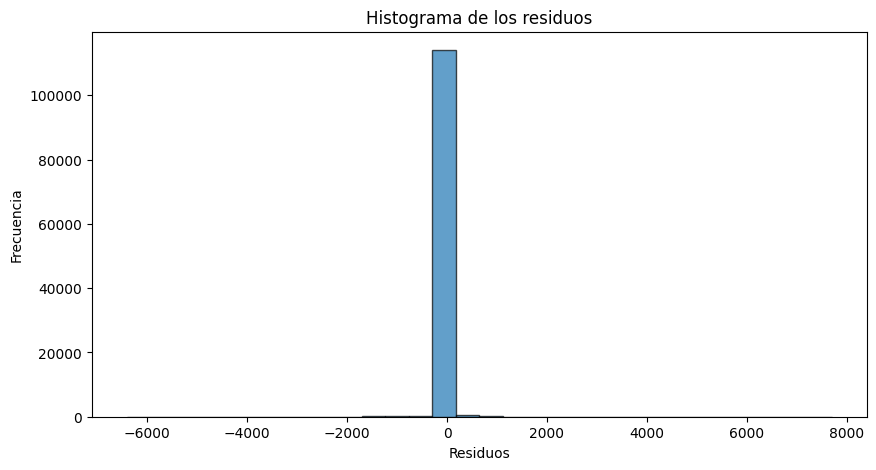

<Figure size 1000x500 with 0 Axes>

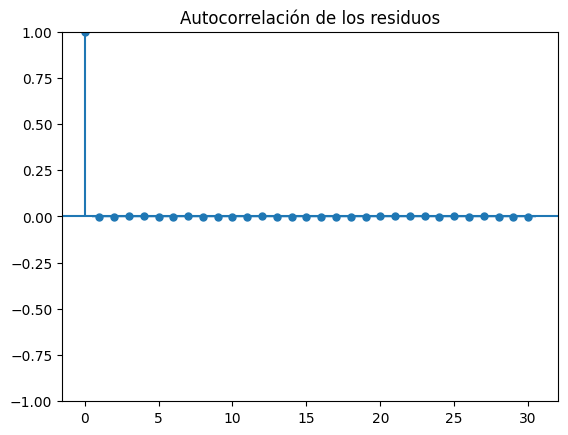


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  6.654458   0.757614


In [ ]:
knn = KNeighborsRegressor(algorithm='ball_tree')
# Crear pipeline con preprocesamiento y modelo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', knn)  # Modelo KNN
])

# Definir hiperparámetros para GridSearch
param_grid = {'model__n_neighbors': [2,10,20],
              'model__leaf_size': [30,50,70]}

# Grid Search con validación cruzada
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

start_train = time.perf_counter()
grid_search.fit(X_train, y_train)  # Entrenar el modelo con GridSearchCV
end_train = time.perf_counter()
train_time = end_train - start_train

# Mejor modelo
best_model = grid_search.best_estimator_

start_pred = time.perf_counter()
y_pred = best_model.predict(X_test)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred

# Evaluación
print(f"\nMejor configuración: {grid_search.best_params_}")
print(f"\nKNN con GridSearch")
print(f"⏳ Tiempo de entrenamiento: {train_time:.4f} segundos")
print(f"⏳ Tiempo de predicción: {pred_time:.4f} segundos")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R²: {r2_score(y_test, y_pred)}")

# Análisis de residuos
residuos = y_test - y_pred

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos, lags=30)
plt.title("Autocorrelación de los residuos")
plt.show()

# Prueba de Ljung-Box
ljung_box_test = sm.stats.acorr_ljungbox(residuos, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test)


###**Random Forest**

Random Forest es un modelo de ensamble basado en múltiples árboles de decisión, donde cada árbol se entrena con una muestra aleatoria del conjunto de datos y realiza predicciones independientes que luego se promedian para mejorar la precisión y reducir el sobreajuste. En el código, se implementa un pipeline con un preprocesador para variables categóricas y un modelo de RandomForestRegressor. Se utiliza GridSearchCV con validación cruzada para optimizar hiperparámetros clave como el número de árboles (n_estimators), la profundidad máxima (max_depth) y la cantidad de características consideradas en cada división (max_features). Una vez encontrado el mejor modelo, se entrena y se evalúa con métricas como MAE, RMSE y R². En el contexto de la predicción de "Diferenciadias", Random Forest puede ser útil al capturar relaciones no lineales y reducir la varianza del modelo. Sin embargo, su rendimiento puede verse afectado si la variable objetivo presenta una gran dispersión o valores extremos, lo que sugiere la necesidad de ajustar los hiperparámetros o probar modelos complementarios para mejorar la precisión.

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)  # Codificar categóricas
], remainder='passthrough')  # Dejar las numéricas sin cambios

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from math import log2

# Calcular el número de características (features)
n_features = X_train.shape[1]

# Crear pipeline con Random Forest
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_jobs=-1, random_state=42))
])

# Definir hiperparámetros para GridSearch
# Changed 'max_features' to use either 'log2' or 'sqrt'
param_grid_rf = {
    'model__n_estimators': [100, 200],  # Número de árboles
    'model__max_depth': [20, 40],  # Profundidad máxima
    'model__max_features': ['log2']  # Número de características a usar en cada división
}

# Medir tiempo de entrenamiento
start_train_rf = time.perf_counter()
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
end_train_rf = time.perf_counter()
train_time_rf = end_train_rf - start_train_rf

# Mejor modelo
best_model_rf = grid_search_rf.best_estimator_

# Medir tiempo de predicción
start_pred_rf = time.perf_counter()
y_pred_rf = best_model_rf.predict(X_test)
end_pred_rf = time.perf_counter()
pred_time_rf = end_pred_rf - start_pred_rf

# Evaluación
print(f"\nRandom Forest Regressor")
print(f"Mejor configuración: {grid_search_rf.best_params_}")
print(f"⏳ Tiempo de entrenamiento: {train_time_rf:.4f} segundos")
print(f"⏳ Tiempo de predicción: {pred_time_rf:.4f} segundos")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf))}")
print(f"R²: {r2_score(y_test, y_pred_rf)}")


Random Forest Regressor
Mejor configuración: {'model__max_depth': 40, 'model__max_features': 'log2', 'model__n_estimators': 200}
⏳ Tiempo de entrenamiento: 2427.7925 segundos
⏳ Tiempo de predicción: 1.0322 segundos
MAE: 22.056469835799913
RMSE: 165.1273254077267
R²: 0.10807137835137848


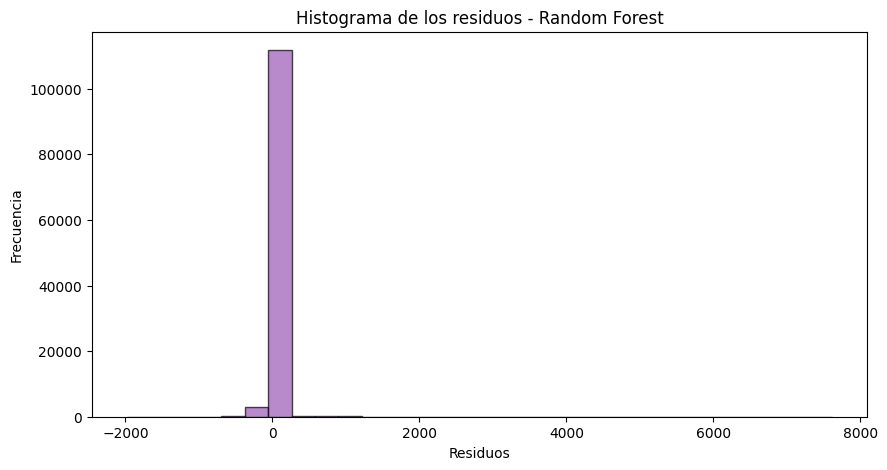

<Figure size 1000x500 with 0 Axes>

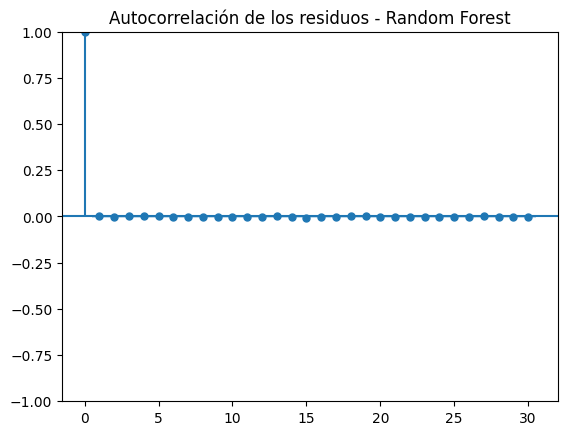


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  2.881491   0.984077

Prueba de Jarque-Bera:
Estadístico de Jarque-Bera: 3422383435.1935
Valor p de Jarque-Bera: 0.0000
Los residuos no siguen una distribución normal (rechazar H0).


<ipython-input-15-98fb0b82dadf>:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


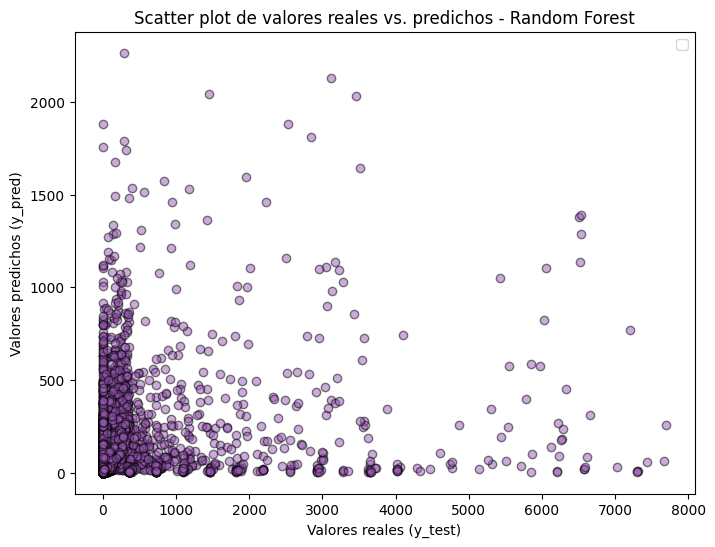

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats

# --------------------- Análisis de residuos ---------------------
residuos_rf = y_test - y_pred_rf

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos_rf, bins=30, edgecolor='k', alpha=0.7, color='#9b59b6')  # Morado claro feminista
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos - Random Forest")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos_rf, lags=30)
plt.title("Autocorrelación de los residuos - Random Forest")
plt.show()

# Prueba de Ljung-Box
ljung_box_test_rf = sm.stats.acorr_ljungbox(residuos_rf, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test_rf)

# Prueba de Jarque-Bera
jb_test_stat, jb_test_p_value = stats.jarque_bera(residuos_rf)
print("\nPrueba de Jarque-Bera:")
print(f"Estadístico de Jarque-Bera: {jb_test_stat:.4f}")
print(f"Valor p de Jarque-Bera: {jb_test_p_value:.4f}")
if jb_test_p_value < 0.05:
    print("Los residuos no siguen una distribución normal (rechazar H0).")
else:
    print("Los residuos siguen una distribución normal (no rechazar H0).")

# Gráfico de dispersión de valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, edgecolors='k', color='#9b59b6')  # Morado claro feminista
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Valores predichos (y_pred)")
plt.title("Scatter plot de valores reales vs. predichos - Random Forest")
plt.legend()
plt.show()


Los resultados del modelo Random Forest muestran limitaciones significativas en su desempeño para predecir la variable "Diferenciadias" en casos de violencia basada en género. El histograma de residuos indica una alta concentración de errores cerca de cero, pero con valores extremos dispersos, lo que sugiere problemas en la capacidad del modelo para generalizar correctamente. La autocorrelación de los residuos muestra independencia temporal, lo cual es positivo, pero la prueba de Jarque-Bera revela que los residuos no siguen una distribución normal, lo que puede afectar la robustez del modelo. El scatter plot de valores reales versus predichos evidencia una fuerte acumulación de predicciones en valores bajos y una dispersión amplia, lo que indica que el modelo no captura bien la variabilidad de la variable objetivo. Además, las métricas de desempeño refuerzan estas observaciones: el R² de 0.108 sugiere que el modelo apenas explica el 10.8\% de la varianza de los datos, mientras que el RMSE de 165.13 indica errores elevados en la predicción. Estos resultados, junto con el MAE de 22.05, reflejan un desempeño pobre del modelo en la tarea de regresión.

###Xgboost

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.3 MB/s eta 0:00:00


XGBoost (Extreme Gradient Boosting) es un algoritmo de aprendizaje automático basado en árboles de decisión que utiliza un enfoque de boosting para mejorar el rendimiento predictivo. Se destaca por su eficiencia computacional y capacidad para manejar datos con valores atípicos y relaciones no lineales. El código implementa un pipeline que incluye un preprocesador de variables categóricas mediante OneHotEncoder y un modelo XGBoost. Luego, se usa GridSearchCV con validación cruzada K-Fold para encontrar los mejores hiperparámetros, optimizando la profundidad del árbol (max_depth), la tasa de aprendizaje (learning_rate) y el número de árboles (n_estimators). Finalmente, el modelo seleccionado se entrena con los mejores parámetros y se evalúa mediante métricas como MAE, RMSE y R².

In [ ]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), variables_categoricas)  # Codificar categóricas
], remainder='passthrough')  # Dejar las numéricas sin cambios

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold



# Crear el pipeline con el preprocesador y el modelo XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor())
])

# Definir los hiperparámetros a optimizar
param_grid = {
    'model__max_depth': [20, 40],           # Profundidad del árbol
    'model__learning_rate': [0.01, 0.1, 0.3], # Tasa de aprendizaje
    'model__n_estimators': [100, 200]   # Número de árboles
    }

# Definir validación cruzada con K-Fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Minimizar MSE (negativo porque GridSearchCV maximiza)
    cv=cv,
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar Grid Search
start_grid = time.perf_counter()
grid_search.fit(X_train, y_train)
end_grid = time.perf_counter()
grid_time = end_grid - start_grid
print(f"⏳ Tiempo de Grid Search: {grid_time:.4f} segundos")

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("🎯 Mejores hiperparámetros encontrados:")
print(best_params)

# Entrenar el modelo final con los mejores hiperparámetros
best_xgb = grid_search.best_estimator_
start_train = time.perf_counter()
best_xgb.fit(X_train, y_train)
end_train = time.perf_counter()
train_time = end_train - start_train
print(f"⏳ Tiempo de entrenamiento final: {train_time:.4f} segundos")

# Medir tiempo de predicción
start_pred = time.perf_counter()
y_pred_x = best_xgb.predict(X_test)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred
print(f"⏳ Tiempo de predicción: {pred_time:.4f} segundos")

# --------------------- Evaluación del modelo ---------------------
mae = mean_absolute_error(y_test, y_pred_x)
mse = mean_squared_error(y_test, y_pred_x)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_x)
mape = np.mean(np.abs((y_test - y_pred_x) / y_test)) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
⏳ Tiempo de Grid Search: 1602.1410 segundos
🎯 Mejores hiperparámetros encontrados:
{'model__learning_rate': 0.01, 'model__max_depth': 20, 'model__n_estimators': 100}
⏳ Tiempo de entrenamiento final: 18.9806 segundos
⏳ Tiempo de predicción: 0.5568 segundos
MAE: 20.1538
RMSE: 166.7020
R²: 0.0910
MAPE: inf%


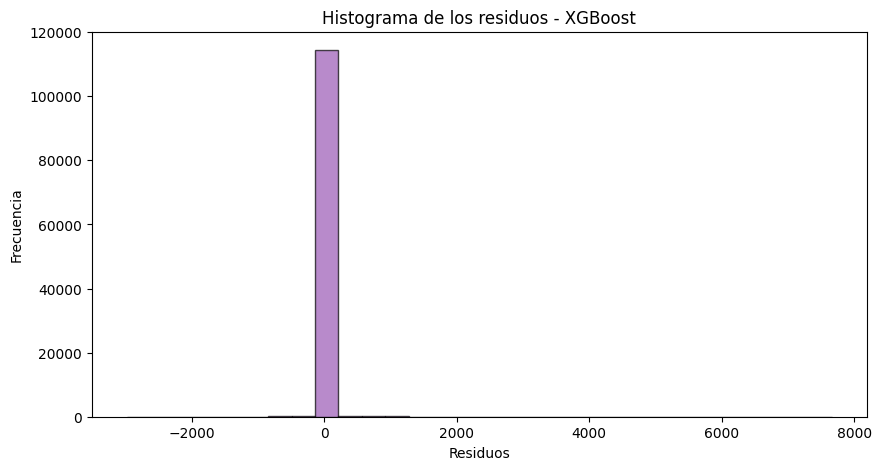

<Figure size 1000x500 with 0 Axes>

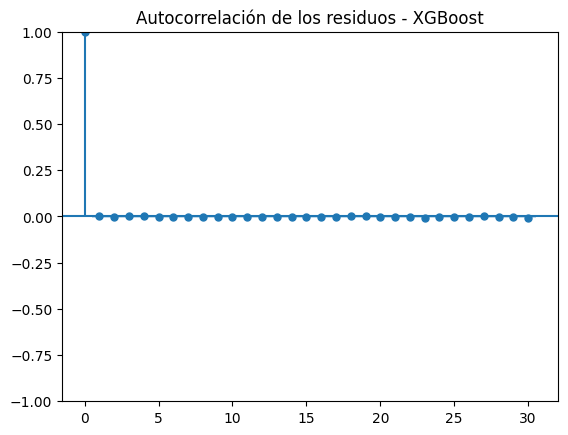


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  2.913866   0.983379


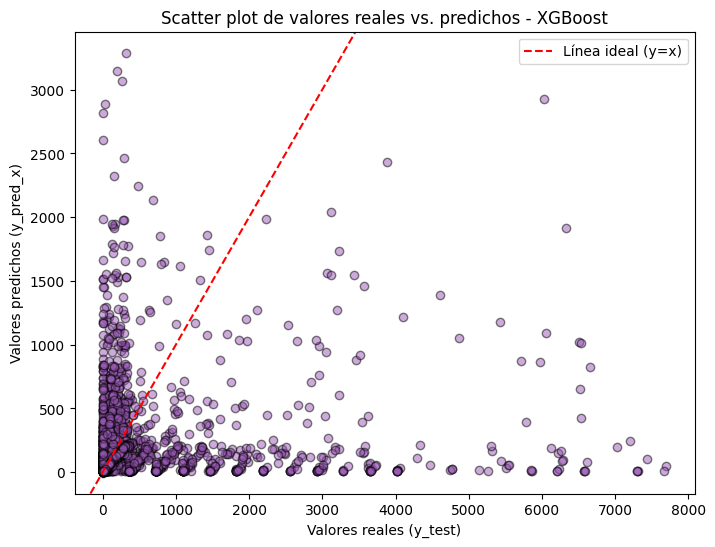

In [ ]:

# --------------------- Análisis de residuos ---------------------
residuos_x = y_test - y_pred_x

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos_x, bins=30, edgecolor='k', alpha=0.7, color='#9b59b6')  # Morado claro feminista
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos - XGBoost")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos_x, lags=30)
plt.title("Autocorrelación de los residuos - XGBoost")
plt.show()

# Prueba de Ljung-Box
ljung_box_test_xgb = sm.stats.acorr_ljungbox(residuos_x, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test_xgb)

# Gráfico de dispersión de valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_x, alpha=0.5, edgecolors='k', color='#9b59b6')  # Morado claro feminista
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Valores predichos (y_pred_x)")
plt.title("Scatter plot de valores reales vs. predichos - XGBoost")
plt.axline((0, 0), slope=1, color="red", linestyle="dashed", label="Línea ideal (y=x)")
plt.legend()
plt.show()

Los resultados obtenidos del modelo XGBoost para predecir el tiempo entre la ocurrencia y la consulta de la víctima de violencia basada en género ("Diferenciadias") muestran un desempeño limitado. El histograma de residuos indica que la mayoría de los errores se concentran en torno a cero, pero con algunos valores atípicos significativos. La prueba de Ljung-Box sugiere que no hay una autocorrelación significativa en los residuos, lo que es positivo en términos de independencia del error. Sin embargo, la baja métrica R² (0.091) indica que el modelo apenas captura la variabilidad de la variable objetivo, lo que sugiere que factores clave pueden estar ausentes en la modelización o que la variable es altamente impredecible. Además, el diagrama de dispersión entre valores reales y predichos muestra una tendencia a subestimar valores altos, lo que podría afectar la utilidad del modelo en casos críticos donde las diferencias de días son largas. El MAE de 20.15 y el RMSE de 166.70 refuerzan la idea de un ajuste insuficiente, y la MAPE reporta un valor infinito, posiblemente debido a valores reales cercanos a cero. Esto resalta la complejidad del problema y la necesidad de explorar características adicionales o ajustes en la arquitectura del modelo.

###Xgboost (Optimizado)

XGBoost es un algoritmo de boosting basado en árboles de decisión, optimizado para eficiencia y precisión en tareas de regresión. La configuración utilizada, objective='reg:squarederror', minimiza el error cuadrático, mientras que tree_method='hist' acelera el entrenamiento en grandes volúmenes de datos. Además, eval_metric='rmse' prioriza la reducción del error medio cuadrático, y early_stopping_rounds=40 detiene el entrenamiento si no hay mejora tras 40 iteraciones, evitando el sobreajuste. En la predicción de "Diferenciadias", esta configuración permite capturar relaciones complejas y mejorar la generalización del modelo.

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold



# Crear el pipeline con el preprocesador y el modelo XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', eval_metric='rmse',  model__early_stopping_rounds=40))
])

# Definir los hiperparámetros a optimizar
param_grid = {
    'model__max_depth': [40],           # Profundidad del árbol
    'model__learning_rate': [0.01, 0.1, 0.3], # Tasa de aprendizaje
    'model__n_estimators': [200]   # Número de árboles
    }

# Definir validación cruzada con K-Fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Minimizar MSE (negativo porque GridSearchCV maximiza)
    cv=cv,
    verbose=2,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutar Grid Search
start_grid = time.perf_counter()
grid_search.fit(X_train, y_train)
end_grid = time.perf_counter()
grid_time = end_grid - start_grid
print(f"⏳ Tiempo de Grid Search: {grid_time:.4f} segundos")

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("🎯 Mejores hiperparámetros encontrados:")
print(best_params)

# Entrenar el modelo final con los mejores hiperparámetros
best_xgb = grid_search.best_estimator_
start_train = time.perf_counter()
best_xgb.fit(X_train, y_train)
end_train = time.perf_counter()
train_time = end_train - start_train
print(f"⏳ Tiempo de entrenamiento final: {train_time:.4f} segundos")

# Medir tiempo de predicción
start_pred = time.perf_counter()
y_pred = best_xgb.predict(X_test)
end_pred = time.perf_counter()
pred_time = end_pred - start_pred
print(f"⏳ Tiempo de predicción: {pred_time:.4f} segundos")

# --------------------- Evaluación del modelo ---------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:58:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "model__early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


⏳ Tiempo de Grid Search: 1493.2448 segundos
🎯 Mejores hiperparámetros encontrados:
{'model__learning_rate': 0.01, 'model__max_depth': 40, 'model__n_estimators': 200}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:00:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "model__early_stopping_rounds" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


⏳ Tiempo de entrenamiento final: 156.2595 segundos
⏳ Tiempo de predicción: 0.9283 segundos
MAE: 17.5613
RMSE: 174.2139
R²: 0.0072
MAPE: inf%


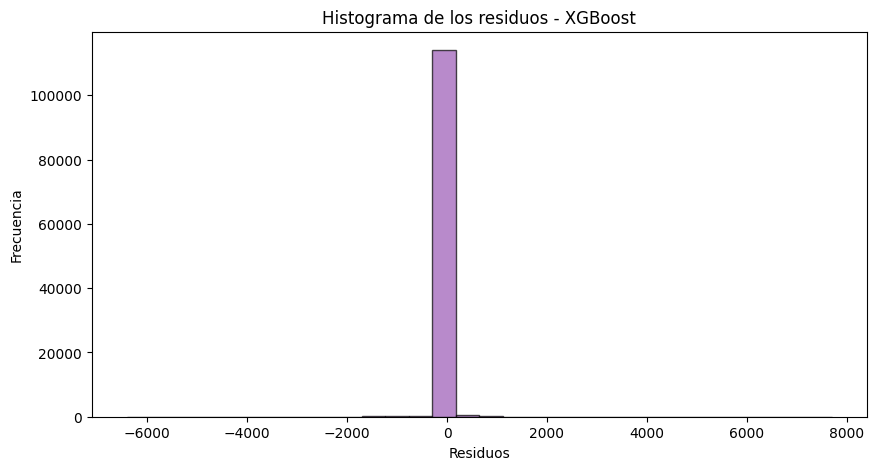

<Figure size 1000x500 with 0 Axes>

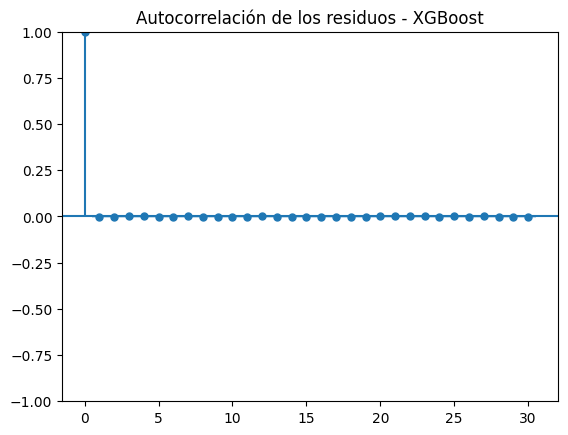


Prueba de Ljung-Box:
     lb_stat  lb_pvalue
10  6.654458   0.757614


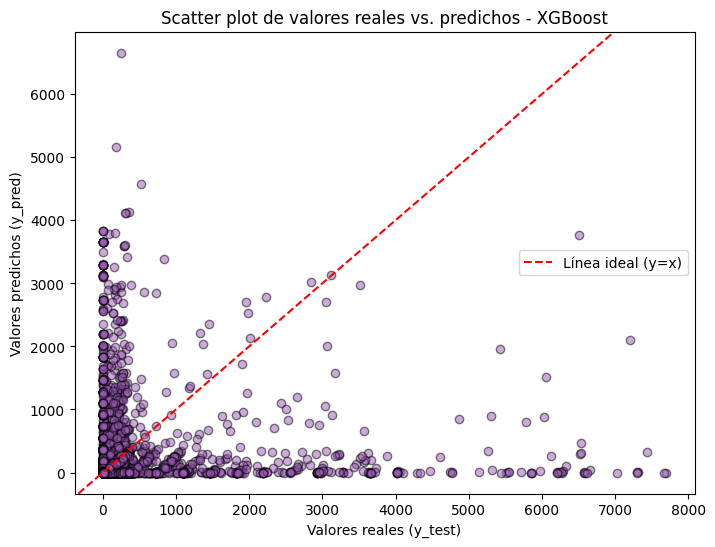

In [ ]:

# --------------------- Análisis de residuos ---------------------
residuos_xgb = y_test - y_pred

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos_xgb, bins=30, edgecolor='k', alpha=0.7, color='#9b59b6')  # Morado claro feminista
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos - XGBoost")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos_xgb, lags=30)
plt.title("Autocorrelación de los residuos - XGBoost")
plt.show()

# Prueba de Ljung-Box
ljung_box_test_xgb = sm.stats.acorr_ljungbox(residuos_xgb, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test_xgb)

# Gráfico de dispersión de valores reales vs. predichos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k', color='#9b59b6')  # Morado claro feminista
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Valores predichos (y_pred)")
plt.title("Scatter plot de valores reales vs. predichos - XGBoost")
plt.axline((0, 0), slope=1, color="red", linestyle="dashed", label="Línea ideal (y=x)")
plt.legend()
plt.show()



###SVR

El modelo **Support Vector Regression (SVR)** es una técnica basada en máquinas de soporte vectorial que busca encontrar una función que prediga la variable objetivo dentro de un margen de tolerancia determinado, minimizando la complejidad del modelo y los errores fuera de este margen. A diferencia de los modelos tradicionales de regresión, SVR es robusto ante valores atípicos y puede capturar relaciones complejas mediante el uso de funciones kernel, como el radial basis function (RBF). En el contexto de la predicción de **"Diferenciadias"**, SVR puede ser una herramienta poderosa, ya que permite modelar patrones no lineales en los tiempos de consulta de las víctimas en función de variables espaciales y temporales. Su capacidad para manejar datos ruidosos y evitar el sobreajuste lo convierte en una alternativa interesante para mejorar la precisión de las estimaciones y entender mejor los factores que influyen en los tiempos de respuesta ante casos de violencia basada en género.

In [ ]:
from sklearn.svm import SVR
from scipy.stats import jarque_bera

# Crear pipeline con SVR
pipeline_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='rbf'))  # Usamos kernel RBF
])

# Definir hiperparámetros para GridSearch
param_grid_svr = {
    'model__C': [0.1, 1, 10],  # Parámetro de penalización
    'model__gamma': ['scale', 'auto'],  # Parámetro gamma
    'model__epsilon': [0.01, 0.1, 1]  # Margen de tolerancia
}

# Medir tiempo de entrenamiento
start_train_svr = time.perf_counter()
grid_search_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=5, scoring='r2', n_jobs=-1)
grid_search_svr.fit(X_train, y_train)
end_train_svr = time.perf_counter()
train_time_svr = end_train_svr - start_train_svr

# Mejor modelo
best_model_svr = grid_search_svr.best_estimator_

# Medir tiempo de predicción
start_pred_svr = time.perf_counter()
y_pred_svr = best_model_svr.predict(X_test)
end_pred_svr = time.perf_counter()
pred_time_svr = end_pred_svr - start_pred_svr

# Evaluación
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

# MAPE
mape_svr = np.mean(np.abs((y_test - y_pred_svr) / y_test)) * 100

print(f"\nSupport Vector Regressor")
print(f"Mejor configuración: {grid_search_svr.best_params_}")
print(f"⏳ Tiempo de entrenamiento: {train_time_svr:.4f} segundos")
print(f"⏳ Tiempo de predicción: {pred_time_svr:.4f} segundos")
print(f"MAE: {mae_svr}")
print(f"RMSE: {rmse_svr}")
print(f"R²: {r2_svr}")
print(f"MAPE: {mape_svr}%")

# Comparación con Random Forest
print("\nComparación con Random Forest:")
print(f"R² Random Forest: {r2_score(y_test, y_pred_rf)}")
print(f"MAPE Random Forest: {np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100}%")

# Análisis de residuos
residuos_svr = y_test - y_pred_svr

# Histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuos_svr, bins=30, edgecolor='k', alpha=0.7, color='#9b59b6')
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos (SVR)")
plt.show()

# ACF de los residuos
plt.figure(figsize=(10, 5))
plot_acf(residuos_svr, lags=30, color='#9b59b6')
plt.title("Autocorrelación de los residuos (SVR)")
plt.show()

# Prueba de Ljung-Box
ljung_box_test_svr = sm.stats.acorr_ljungbox(residuos_svr, lags=[10], return_df=True)
print("\nPrueba de Ljung-Box:")
print(ljung_box_test_svr)

# Test de Jarque-Bera
jb_stat, jb_pvalue = jarque_bera(residuos_svr)
print(f"\nTest de Jarque-Bera: Estadístico={jb_stat}, p-valor={jb_pvalue}")

# Curvas de la variable objetivo vs predicha
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Real', alpha=0.7, color='#9b59b6')
plt.plot(y_pred_svr, label='Predicho (SVR)', alpha=0.7, linestyle='dashed', color='#9b59b6')
plt.xlabel("Índice")
plt.ylabel("Diferencia en Días")
plt.title("Curvas de la variable objetivo vs predicha (SVR)")
plt.legend()
plt.show()